In [39]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

In [40]:
# Declare the credentials
client_id = 'a76bfd98001a4aff8bd958ea948403e1'
client_secret = '2545a1f2c3864049a42ff28637c3db70'
redirect_uri='http://localhost:7777/callback'
username = 'ethan.falcao'

In [41]:
# Authorization flow
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [42]:
# Getting features for each song
def fetch_audio_features(sp, df):
    playlist = df[['track_id','track_name']] 
    index = 0
    audio_features = []
    
    # Make the API request
    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 70, 0])
        index += 70
    
    # Create an empty list to feed in different charactieritcs of the tracks
    features_list = []
    #Create keys-values of empty lists inside nested dictionary for album
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['acousticness'],
                              features['energy'], 
                              features['tempo'],
                              features['instrumentalness'], 
                              features['loudness'],
                              features['liveness'],
                              features['duration_ms'],
                              features['key'],
                              features['valence'],
                              features['speechiness'],
                              features['mode']
                             ])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'acousticness', 'energy','tempo', 
                                                             'instrumentalness', 'loudness', 'liveness','duration_ms', 'key',
                                                             'valence', 'speechiness', 'mode'])
    
    # Create the final df, using the 'track_id' as index for future reference
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_name', inplace=True, drop=True)
    return df_playlist_audio_features

In [43]:
# # Getting playlist IDs from each of Spotify's playlists
playlists = sp.user_playlists('spotify')
spotify_playlist_ids = []
while playlists:
    for i, playlist in enumerate(playlists['items']):
        spotify_playlist_ids.append(playlist['uri'][-22:])
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None
spotify_playlist_ids[:25]

['37i9dQZF1DXcBWIGoYBM5M',
 '37i9dQZF1DX0XUsuxWHRQd',
 '37i9dQZF1DX1lVhptIYRda',
 '37i9dQZF1DX10zKzsJ2jva',
 '37i9dQZF1DX4JAvHpjipBk',
 '37i9dQZF1DX4sWSpwq3LiO',
 '37i9dQZF1DX4SBhb3fqCJd',
 '37i9dQZF1DWXRqgorJj26U',
 '37i9dQZF1DX4dyzvuaRJ0n',
 '37i9dQZF1DXcF6B6QPhFDv',
 '37i9dQZF1DWXJfnUiYjUKT',
 '37i9dQZF1DXcRXFNfZr7Tp',
 '37i9dQZF1DX4o1oenSJRJd',
 '37i9dQZF1DXbTxeAdrVG2l',
 '37i9dQZF1DX4UtSsGT1Sbe',
 '37i9dQZF1DWTJ7xPn4vNaz',
 '37i9dQZF1DXaKIA8E7WcJj',
 '37i9dQZF1DWSV3Tk4GO2fq',
 '37i9dQZF1DWTwnEm1IYyoj',
 '37i9dQZF1DX2A29LI7xHn1',
 '37i9dQZF1DX2RxBh64BHjQ',
 '37i9dQZF1DWVA1Gq4XHa6U',
 '37i9dQZF1DWY4xHQp97fN6',
 '37i9dQZF1DWX3387IZmjNa',
 '37i9dQZF1DWYkaDif7Ztbp']

In [55]:
len(spotify_playlist_ids)

1112

In [56]:
#Getting tracks from Spotify playlists
# Creating a function to get the first 50 tracks IDs from a playlist
def getTrackIDs(playlist_id):
    playlist = sp.user_playlist('spotify', playlist_id)
    for item in playlist['tracks']['items'][:50]:
        track = item['track']
        ids.append(track['id'])
    return

In [57]:
# Creating a function get features of each track from track id
def getTrackFeatures(track_id):
  meta = sp.track(track_id)
  features = sp.audio_features(track_id)

  # meta
  track_id = track_id
  name = meta['name']
  album = meta['album']['name']
  artist = meta['album']['artists'][0]['name']
  release_date = meta['album']['release_date']
  length = meta['duration_ms']
  popularity = meta['popularity']

  # features
  acousticness = features[0]['acousticness']
  danceability = features[0]['danceability']
  energy = features[0]['energy']
  instrumentalness = features[0]['instrumentalness']
  liveness = features[0]['liveness']
  loudness = features[0]['loudness']
  speechiness = features[0]['speechiness']
  tempo = features[0]['tempo']
  time_signature = features[0]['time_signature']

  track = [track_id, name, album, artist, release_date, length, popularity, danceability, acousticness, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
  return track

In [ ]:
#Getting tracks from Spotify playlists
# Creating a function to get the first 50 tracks IDs from a playlist

#def getTrackIDs(playlist_id):
 #   playlist = sp.user_playlist('spotify', playlist_id)
 #   for item in playlist['tracks']['items'][:50]:
 #       track = item['track']
 #       ids.append(track['id'])
 #   return

In [59]:
#Getting tracks from Spotify playlists
# Creating a function to get the first 50 tracks IDs from a playlist
def getTrackIDs(playlist_id):
    try:
        playlist = sp.playlist(playlist_id)
        for item in playlist['tracks']['items'][:50]:
            track = item['track']
            ids.append(track['id'])
    except Exception as e:
        print(f"Error fetching playlist {playlist_id}: {e}")


In [62]:
# %%time
# # Gathering track ids
ids = []
for x in spotify_playlist_ids[:200]:
    getTrackIDs(x)
ids[:5]

Error fetching playlist 37i9dQZF1DXcRXFNfZr7Tp: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DXc0fQ4sGOnVJ: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DXa41CMuUARjl: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DX5GiUwx1edLZ: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DX2VvACCrgjrt: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DWYHkSks5rujC: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DWZreqadA03A8: 'NoneType' object is not subscriptable
Error fetching playlist 37i9dQZF1DXdwF9DytRe8w: 'NoneType' object is not subscriptable


['7x9aauaA9cu6tyfpHnqDLo',
 '2IGMVunIBsBLtEQyoI1Mu7',
 '3RaCGXCiiMufRPoexXxGkV',
 '3IX0yuEVvDbnqUwMBB3ouC',
 '1vYXt7VSjH9JIM5oRRo7vA']

In [63]:
# %%time
 # loop over track ids to get audio features for each track
tracks = []
for i in range(len(ids)):
    try:  
        track = getTrackFeatures(ids[i])
        tracks.append(track)
    except:
        pass

 # create dataset
df = pd.DataFrame(tracks, columns = ['track_id', 'name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])
df.head()

,track_id,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,7x9aauaA9cu6tyfpHnqDLo,Seven (feat. Latto) (Explicit Ver.),Seven (feat. Latto),Jung Kook,2023-07-14,184400,98,0.802,0.31100,0.832,0.000000,0.0815,-4.107,0.0434,124.997,4
1,2IGMVunIBsBLtEQyoI1Mu7,Paint The Town Red,Paint The Town Red,Doja Cat,2023-08-04,231750,100,0.868,0.26900,0.538,0.000003,0.0901,-8.603,0.1740,99.968,4
2,3RaCGXCiiMufRPoexXxGkV,Slime You Out (feat. SZA),Slime You Out,Drake,2023-09-15,310490,84,0.483,0.50800,0.408,0.000000,0.2590,-9.243,0.0502,88.880,3
3,3IX0yuEVvDbnqUwMBB3ouC,bad idea right?,GUTS,Olivia Rodrigo,2023-09-08,184783,90,0.627,0.00193,0.879,0.000007,0.0647,-3.446,0.0955,129.979,4
4,1vYXt7VSjH9JIM5oRRo7vA,Dance The Night - From Barbie The Album,Dance The Night (From Barbie The Album),Dua Lipa,2023-05-25,176579,96,0.671,0.02070,0.845,0.000000,0.3290,-4.930,0.0480,110.056,4


In [64]:
len(df)

9403

In [67]:
# Dropping duplicated songs
df = df.drop_duplicates(subset=['track_id'])
df['track_id'].value_counts()

track_id
7x9aauaA9cu6tyfpHnqDLo    1
2gqzTQEn4g5ly0n5ScdMx0    1
1rrWt6UuUMVjUvDhZvjVSO    1
123zFAGx0F5ScgrLrCWGDX    1
7FJvIEwZ0euCr67yihS2aW    1
                         ..
3FUkmuhMgkxwvYuV8lvGwU    1
4Y4fGklrIKERF6TixxvLQi    1
0XNm4jXda363NhHBoOp5II    1
7FpFV1oQhhZm6Vyj7K5FcS    1
1LmwMw97uG572wZ3hohkNt    1
Name: count, Length: 8261, dtype: int64

In [68]:
len(df)

8261

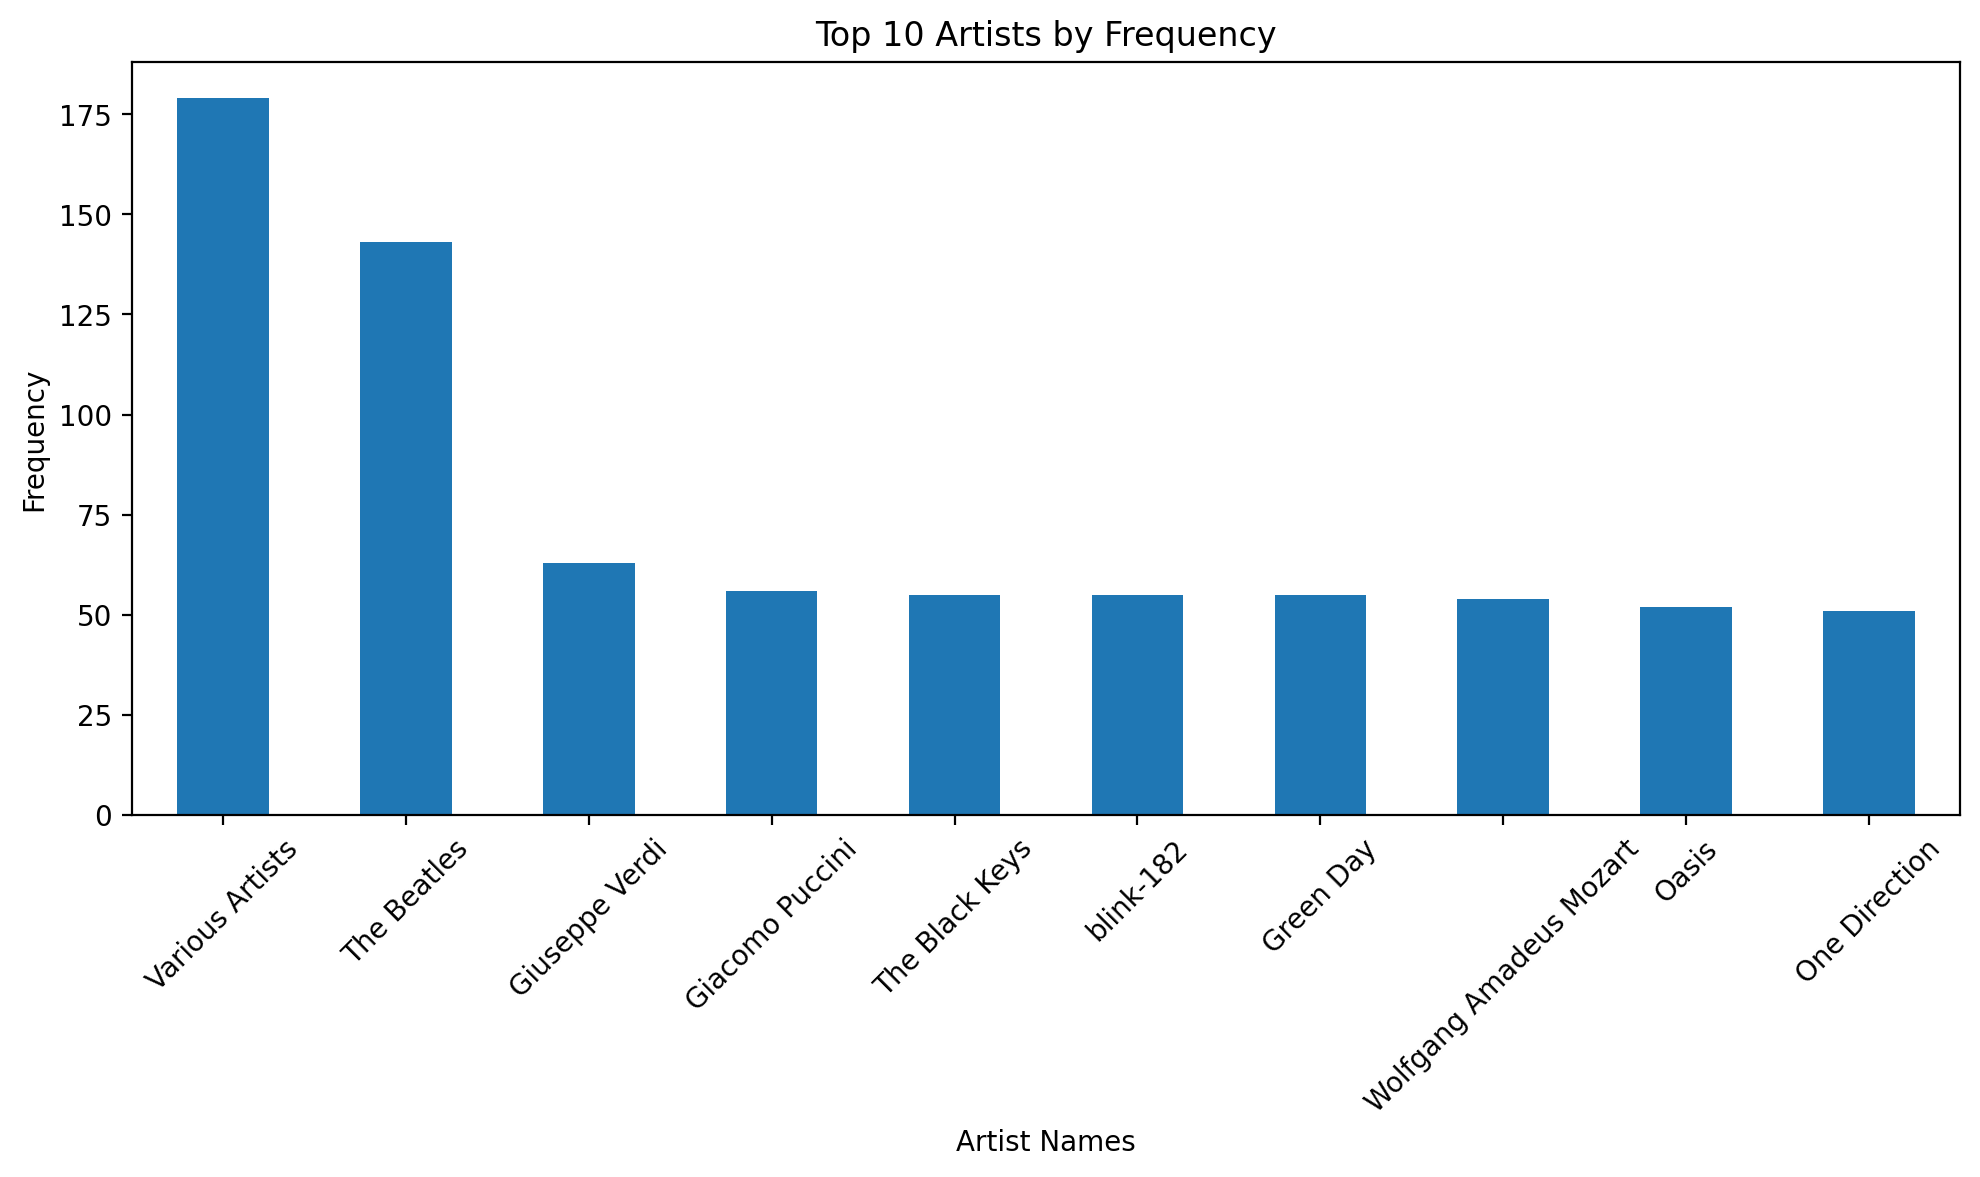

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your data into a DataFrame called 'df'

# Get the top 10 artists based on their frequency
top_10_artists = df['artist'].value_counts().head(10)

# Create a bar plot
plt.figure(figsize=(10, 6))
top_10_artists.plot(kind='bar')
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees
plt.xlabel('Artist Names')
plt.ylabel('Frequency')
plt.title('Top 10 Artists by Frequency')
plt.tight_layout()
plt.show()

In [31]:
# Getting top 50 tracks from user
results = sp.current_user_top_tracks(limit=1000, offset=0,time_range='short_term')
#https://github.com/lognorman20/spotify_recommender/blob/main/data_engineering.ipynb

In [32]:
# Convert it to Dataframe
track_name = []
track_id = []
artist = []
album = []
duration = []
popularity = []
for i, items in enumerate(results['items']):
        track_name.append(items['name'])
        track_id.append(items['id'])
        artist.append(items["artists"][0]["name"])
        duration.append(items["duration_ms"])
        album.append(items["album"]["name"])
        popularity.append(items["popularity"])

# Create the final df   
df_favourite = pd.DataFrame({ "track_name": track_name, 
                             "album": album, 
                             "track_id": track_id,
                             "artist": artist, 
                             "duration": duration, 
                             "popularity": popularity})

df_favourite.head()

,track_name,album,track_id,artist,duration,popularity
0,Wake Up,Wake Up,5rfMpJorQrwpvCOfDM7Q5L,Dom Corleo,112153,61
1,Flight's Booked,"Honestly, Nevermind",6Yj7Zhxt73uvwFFvzQXdxO,Drake,254407,68
2,Texts Go Green,"Honestly, Nevermind",4FIgHqXd4KkOwxrGeLDYM2,Drake,308820,65
3,Down Hill,"Honestly, Nevermind",3N3d4OWbPVxTQVBFqNyykk,Drake,250864,58
4,Patience (feat. Don Toliver),Pink Tape,05grSYrVwYw58YMOdJceyz,Lil Uzi Vert,262429,70


In [33]:
len(df_favourite)

50

In [3]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id="a76bfd98001a4aff8bd958ea948403e1",
                                               client_secret="2545a1f2c3864049a42ff28637c3db70",
                                               redirect_uri="http://localhost:7777/callback",
                                               scope="user-library-read"))

results = sp.current_user_saved_tracks()
for idx, item in enumerate(results['items']):
    
    track = item['track']
    print(idx, track['artists'][0]['name'], " – ", track['name'])

0 Gunna  –  Outstanding
1 Gunna  –  One Call
2 Lil Uzi Vert  –  Patience (feat. Don Toliver)
3 NAV  –  Tap (feat. Meek Mill)
4 SBTRKT  –  FORWARD
5 KayCyy  –  Look What I Found (feat. Lancey Foux)
6 Wegz  –  Keify Keda
7 Dom Corleo  –  Wake Up
8 NAV  –  Ain't Goin Back
9 NAV  –  Yessir
10 NAV  –  Relax
11 NAV  –  Free Santana (feat. Lil Duke)
12 Drake  –  Down Hill
13 Drake  –  Flight's Booked
14 Drake  –  Tie That Binds
15 Drake  –  Texts Go Green
16 Drake  –  A Keeper
17 Drake  –  Calling My Name
18 BlackMayo  –  Jus Know, Pt. 4
19 Kanye West  –  Mercy


In [6]:
# Fetch the top-50 songs of the user
if token:
    sp = spotipy.Spotify(auth=token)
    results = sp.current_user_top_tracks(limit=50,offset=0,time_range='medium_term')
    for song in range(50):
        list = []
        list.append(results)
        with open('top50_data.json', 'w', encoding='utf-8') as f:
            json.dump(list, f, ensure_ascii=False, indent=4)
else:
    print("Can't get token for", username)

In [8]:
# Open the JSON file to Python objects
with open('top50_data.json') as f:
  data = json.load(f)

In [9]:
len(data[0]['items'])

50

In [10]:
list_of_results = data[0]["items"]
list_of_artist_names = []
list_of_artist_uri = []
list_of_song_names = []
list_of_song_uri = []
list_of_durations_ms = []
list_of_explicit = []
list_of_albums = []
list_of_popularity = []

for result in list_of_results:
    result["album"]
    this_artists_name = result["artists"][0]["name"]
    list_of_artist_names.append(this_artists_name)
    this_artists_uri = result["artists"][0]["uri"]
    list_of_artist_uri.append(this_artists_uri)
    list_of_songs = result["name"]
    list_of_song_names.append(list_of_songs)
    song_uri = result["uri"]
    list_of_song_uri.append(song_uri)
    list_of_duration = result["duration_ms"]
    list_of_durations_ms.append(list_of_duration)
    song_explicit = result["explicit"]
    list_of_explicit.append(song_explicit)
    this_album = result["album"]["name"]
    list_of_albums.append(this_album)
    song_popularity = result["popularity"]
    list_of_popularity.append(song_popularity)

In [11]:
# Convert the pulled content to a pandas df
all_songs = pd.DataFrame(
    {'artist': list_of_artist_names,
     'artist_uri': list_of_artist_uri,
     'song': list_of_song_names,
     'song_uri': list_of_song_uri,
     'duration_ms': list_of_durations_ms,
     'explicit': list_of_explicit,
     'album': list_of_albums,
     'popularity': list_of_popularity
     
    })

In [12]:
all_songs.sort_values('popularity', ascending=False)

,artist,artist_uri,song,song_uri,duration_ms,explicit,album,popularity
13,Gunna,spotify:artist:2hlmm7s2ICUX0LVIhVFlZQ,fukumean,spotify:track:4rXLjWdF2ZZpXCVTfWcshS,125040,True,a Gift & a Curse,96
22,Drake,spotify:artist:3TVXtAsR1Inumwj472S9r4,Search & Rescue,spotify:track:7aRCf5cLOFN1U7kvtChY1G,272112,True,Search & Rescue,86
0,Drake,spotify:artist:3TVXtAsR1Inumwj472S9r4,On The Radar Freestyle,spotify:track:1L0OmJV0LnPDWuHCIGmBV6,275280,True,On The Radar Freestyle,83
47,Drake,spotify:artist:3TVXtAsR1Inumwj472S9r4,Spin Bout U,spotify:track:2ZL7WZcjuYKi1KUDtp4kCC,214588,True,Her Loss,83
36,J Hus,spotify:artist:2a0uxJgbvvIRI4GX8pYfcr,Who Told You (feat. Drake),spotify:track:40EXFgNMOIQRQOwJZ8mJkC,208917,True,Who Told You (feat. Drake),81
9,Drake,spotify:artist:3TVXtAsR1Inumwj472S9r4,Sticky,spotify:track:4rmVZajAF7PkrCagGPHbqa,243227,True,"Honestly, Nevermind",77
8,Drake,spotify:artist:3TVXtAsR1Inumwj472S9r4,Hours In Silence,spotify:track:0sSRLXxknVTQDStgU1NqpY,399153,True,Her Loss,76
1,Drake,spotify:artist:3TVXtAsR1Inumwj472S9r4,Privileged Rappers,spotify:track:7l2nxyx7IkBX5orhkALg0V,160821,True,Her Loss,76
35,Drake,spotify:artist:3TVXtAsR1Inumwj472S9r4,Jumbotron Shit Poppin,spotify:track:2ZlABhxMMa43COmZ97kKsJ,137151,True,Her Loss,75
38,Drake,spotify:artist:3TVXtAsR1Inumwj472S9r4,TSU,spotify:track:4s7QLoImIwmPi9L6dq1nVW,308755,True,Certified Lover Boy,75


In [4]:
import requests
import base64

# Define the authentication options
auth_url = 'https://accounts.spotify.com/api/token'
auth_headers = {
    'Authorization': 'Basic ' + base64.b64encode(f'{client_id}:{client_secret}'.encode()).decode()
}
auth_data = {
    'grant_type': 'client_credentials'
}
# Make the POST request
response = requests.post(auth_url, headers=auth_headers, data=auth_data)

if response.status_code == 200:
    token = response.json().get('access_token')
    print(f'Token: {token}')
else:
    print(f'Error: {response.status_code} - {response.text}')


Token: BQA9Mzdg4TAbPjVKiFZygHRE-P-5ZwT6all09bSIj7QCjtSta-fZLWsj8SGwQZLkPKTgvgpyC_E12dLSIN5sU1PzPDC26K5eRRM_4amPy4W8EZUIff8
